In [95]:
import numpy as np
import pandas as pd

In [96]:
# Создание датафрейма с погодой
meteo = pd.read_csv('open-meteo-45.31N39.66E80m.csv')
meteo['time'] = pd.to_datetime(meteo['time'])
meteo.set_index('time', inplace=True)
monthly_weather = meteo.resample('M').mean() # Усреднение значений по месяцам

# Создание ключа для последующего join
monthly_weather['month'] = pd.date_range(start='2016-01-01', periods=96, freq='MS')
monthly_weather.set_index('month', inplace=True) 

In [97]:
# Создание датафрейма с данными о засеве полей
data = [
    ['2016', '221', 'Кук/зерно', 'нет', 0, 0, 0, 0, 0, 0, 0, '60'],
    ['2016', '226', 'Оз.пшеница', 'нет', 100, 40, 150, 0, 0, 0, 0, '57.3'],
    ['2017', '221', 'Соя', 'Кук/зерно', 0, 0, 0, 0, 0, 0, 0, '17.2'],
    ['2017', '226', 'Оз.ячмень', 'Оз.пшеница', 200, 40, 0, 0, 0, 0, 0, '47.4'],
    ['2018', '221', 'Оз.пшеница', 'Соя', 200, 50, 150, 0, 0, 0, 0, '74.2'],
    ['2018', '226', 'Сах.свекла', 'Оз.ячмень', 0, 200, 0, 200, 200, 0, 0, '291.7'],
    ['2019', '221', 'Сах.свекла', 'Оз.пшеница', 0, 200, 0, 200, 200, 0, 0, '618.9'],
    ['2019', '226', 'Оз.пшеница', 'Сах.свекла', 200, 0, 150, 0, 0, 0, 0, '69'],
    ['2020', '221', 'Оз.пшеница', 'Сах.свекла', 200, 0, 200, 0, 0, 0, 0, '51.7'],
    ['2020', '226', 'Кук/гибр', 'Оз.пшеница', 0, 0, 0, 0, 0, 0, 0, np.nan],
    ['2021', '221', 'Кук/гибр', 'Оз.пшеница', 0, 0, 0, 0, 0, 0, 0, np.nan],
    ['2021', '226', 'Соя', 'Кук/гибр', 0, 0, 0, 0, 0, 0, 0, '17'],
    ['2022', '221', 'Оз.пшеница', 'Кук/гибр', 400, 0, 0, 0, 0, 200, 0, '72.6'],
    ['2022', '226', 'Оз.пшеница', 'Соя', 200, 0, 0, 0, 0, 200, 0, '83.3'],
    ['2023', '221', 'Кук/гибр', 'Оз.пшеница', 0, 0, 0, 0, 0, 0, 0, '47.7'],
    ['2023', '226', 'Кук/гибр', 'Оз.пшеница', 0, 0, 0, 0, 0, 0, 30, '44.3']
]

df = pd.DataFrame(data, columns=['ГОД', '№ поля', 'Культура (Сорт/Гибрид)', 'Предыдущая культура', 'Ам.селитра', 'Аммофос', 'Диаммофоска', 'Карбамид', 'Калий хлористый', 'Тукосмесь', 'Навоз', 'Урожайность'])
df['ГОД'] = df['ГОД'].astype(int)
df['Урожайность'] = df['Урожайность'].astype(float)
df['date'] = df['ГОД'].apply(lambda x: pd.date_range(start=f"{x-1}-09-01", periods=12, freq='MS'))

# Расширение DataFrame по колонке 'date', чтобы каждая строка повторялась для каждого месяца в диапазоне дат, и сброс индекса.
df = df.explode('date').reset_index(drop=True)
df.set_index('date', inplace=True)


In [98]:
# Левый джоин по погоде
merged_data = monthly_weather.merge(df, left_index=True, right_index=True, how='left').iloc[:-4].fillna(47.7).drop('ГОД', axis=1)
merged_data[['№ поля']] = merged_data[['№ поля']].astype('int64')

In [99]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2016-01-01 to 2023-08-01
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   temperature_2m (°C)             184 non-null    float64
 1   relative_humidity_2m (%)        184 non-null    float64
 2   dew_point_2m (°C)               184 non-null    float64
 3   apparent_temperature (°C)       184 non-null    float64
 4   precipitation (mm)              184 non-null    float64
 5   rain (mm)                       184 non-null    float64
 6   snowfall (cm)                   184 non-null    float64
 7   snow_depth (m)                  184 non-null    float64
 8   weather_code (wmo code)         184 non-null    float64
 9   pressure_msl (hPa)              184 non-null    float64
 10  surface_pressure (hPa)          184 non-null    float64
 11  cloud_cover (%)                 184 non-null    float64
 12  cloud_cover_mid (

In [100]:
# Меняю местами поля чтобы сначала шло 221, затем 226
merged_data_first = merged_data[merged_data['№ поля'] == 221].drop('№ поля', axis=1)
merged_data_second = merged_data[merged_data['№ поля'] == 226].drop('№ поля', axis=1)
merged_data = pd.concat([merged_data_first.iloc[8:], merged_data_second.iloc[8:]], ignore_index=True)


In [101]:
merged_data.shape

(168, 26)

In [102]:
# Скалирование численных признаков и кодирование категориальных признаков
from sklearn.preprocessing import LabelEncoder, StandardScaler
cat_cols = ['Культура (Сорт/Гибрид)', 'Предыдущая культура']
num_cols = [col for col in merged_data.columns if col not in cat_cols and col not in ['№ поля', 'Урожайность']]
scaler = StandardScaler()
le = LabelEncoder()
merged_data[num_cols] = scaler.fit_transform(merged_data[num_cols])
label_encoders = {}
for column in cat_cols:
    le = LabelEncoder()
    merged_data[column] = le.fit_transform(merged_data[column])
    label_encoders[column] = le


c:\Python\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Python\Lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Python\Lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Python\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_spa

In [103]:
merged_data.describe()

,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),weather_code (wmo code),pressure_msl (hPa),...,Культура (Сорт/Гибрид),Предыдущая культура,Ам.селитра,Аммофос,Диаммофоска,Карбамид,Калий хлористый,Тукосмесь,Навоз,Урожайность
count,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,...,168.00000,168.000000,1.680000e+02,168.000000,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,1.680000e+02,168.000000
mean,3.172066e-17,-2.022192e-16,-2.114711e-17,3.172066e-17,1.533165e-16,-1.215959e-16,-3.436405e-17,-1.850372e-17,4.229421e-17,-1.908526e-15,...,1.50000,2.428571,-1.057355e-17,0.000000,-2.114711e-17,-5.815454e-17,-5.815454e-17,-8.458842e-17,-2.114711e-17,109.314286
std,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00,...,1.40572,1.549856,1.002990e+00,1.002990,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00,1.002990e+00,155.752142
min,-1.742803e+00,-2.622819e+00,-1.845012e+00,-1.678783e+00,-1.934671e+00,-1.884699e+00,-4.296232e-01,-3.596853e-01,-1.827192e+00,-2.112843e+00,...,0.00000,0.000000,-7.977240e-01,-0.506124,-5.157106e-01,-4.082483e-01,-4.082483e-01,-4.082483e-01,-2.773501e-01,17.000000
25%,-9.470332e-01,-4.803716e-01,-8.311591e-01,-9.233400e-01,-7.193674e-01,-7.143705e-01,-4.296232e-01,-3.596853e-01,-8.752001e-01,-8.709875e-01,...,0.00000,2.000000,-7.977240e-01,-0.506124,-5.157106e-01,-4.082483e-01,-4.082483e-01,-4.082483e-01,-2.773501e-01,47.400000
50%,-4.283913e-02,2.411745e-01,2.093330e-02,-7.495425e-02,-8.187018e-02,-1.196311e-01,-4.296232e-01,-3.596853e-01,-1.234365e-01,-1.554609e-03,...,1.00000,2.000000,-7.977240e-01,-0.506124,-5.157106e-01,-4.082483e-01,-4.082483e-01,-4.082483e-01,-2.773501e-01,49.700000
75%,9.414040e-01,7.892541e-01,7.935132e-01,9.838095e-01,6.347157e-01,7.069711e-01,4.991958e-02,-1.707878e-01,6.247865e-01,8.106533e-01,...,3.00000,4.000000,7.977240e-01,0.072303,-5.157106e-01,-4.082483e-01,-4.082483e-01,-4.082483e-01,-2.773501e-01,74.200000
max,1.632596e+00,1.454923e+00,1.831219e+00,1.665223e+00,2.645776e+00,2.389314e+00,5.729505e+00,5.299830e+00,2.590346e+00,2.032669e+00,...,4.00000,5.000000,2.393172e+00,2.386012,2.372269e+00,2.449490e+00,2.449490e+00,2.449490e+00,3.605551e+00,618.900000


In [104]:
# Создание временных рядов  
sequence_length = 9 # Надо брать 9 месяцев сентябрь-май
features = []
targets = []

for i in range(0, len(merged_data) - sequence_length, 12):
    features.append(merged_data.iloc[i:i+sequence_length].drop('Урожайность', axis=1).values)
    targets.append(merged_data.iloc[i+sequence_length]['Урожайность'])

features = np.array(features, dtype='float64') # 14 рядов
targets = np.array(targets)


In [105]:
targets.shape

(14,)

In [106]:
features.shape

(14, 9, 25)

In [107]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
tf.random.set_seed(1337)

n_samples = 14
time_steps = 9
n_features = 25
np.random.seed(1337)

# Моделирование
model = Sequential([
    LSTM(64, activation='relu', input_shape=(time_steps, n_features)), 
    Dense(1)
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

history = model.fit(
    features, targets,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
)


Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 45063.0000 - mse: 45063.0000 - val_loss: 3052.5891 - val_mse: 3052.5891
Epoch 2/200
1/1 [==============================] - 0s 24ms/step - loss: 44999.6055 - mse: 44999.6055 - val_loss: 3040.8855 - val_mse: 3040.8855
Epoch 3/200
1/1 [==============================] - 0s 24ms/step - loss: 44935.0273 - mse: 44935.0273 - val_loss: 3029.0706 - val_mse: 3029.0706
Epoch 4/200
1/1 [==============================] - 0s 26ms/step - loss: 44868.3789 - mse: 44868.3789 - val_loss: 3016.9150 - val_mse: 3016.9150
Epoch 5/200
1/1 [==============================] - 0s 27ms/step - loss: 44798.3750 - mse: 44798.3750 - val_loss: 3004.2070 - val_mse: 3004.2070
Epoch 6/200
1/1 [==============================] - 0s 28ms/step - loss: 44722.7617 - mse: 44722.7617 - val_loss: 2990.8975 - val_mse: 2990.8975
Epoch 7/200
1/1 [==============================] - 0s 25ms/step - loss: 44639.3477 - mse: 44639.3477 - val_loss: 2976.7363 - val_mse: 2976

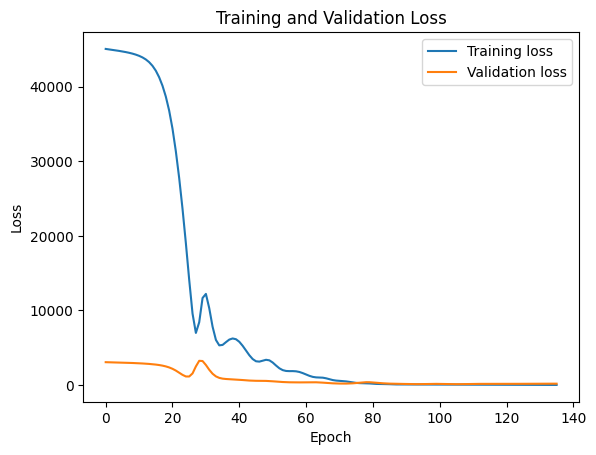

In [108]:
import matplotlib.pyplot as plt

# График функций потерь
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [109]:
# Оценка модели
preds = model.predict(features)
from sklearn.metrics import mean_squared_error
mean_squared_error(preds, targets)

1/1 [==============================] - 0s 104ms/step


45.2453555439909

In [ ]:
import tifffile
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
from sklearn.metrics import mean_squared_error
from dateutil.parser import parse
torch.manual_seed(0)

def extract_image_number(file_name):
        return int(file_name.split('_')[0])

class CombinedDataset(Dataset):
    def __init__(self, image_dir, features, targets, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(image_dir), key=extract_image_number)
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.image_files) - 1  

    # Функция для расчета индекса признаков поля к конкретному году фото
    def count_feature_idx(self, image_file):
        date_part = image_file.split('_')[1].split('.')[0]
        date_obj = parse(date_part)
        start_date = parse("2016-01-01")
        years_difference = date_obj.year - start_date.year
        return years_difference
    
    # К изображению добавлено матрица признаков погоды и поля вплоть до года изображения    
    def __getitem__(self, idx):
        current_img_path = os.path.join(self.image_dir, self.image_files[idx])
        next_img_path = os.path.join(self.image_dir, self.image_files[idx + 1])
        current_img = tifffile.imread(current_img_path)
        next_img = tifffile.imread(next_img_path)
        current_img = cv2.resize(current_img / 10000, (256, 256))  
        next_img = cv2.resize(next_img / 10000, (256, 256))  
        if self.transform:
            current_img = self.transform(current_img)
            next_img = self.transform(next_img)
        feature_idx = self.count_feature_idx(self.image_files[idx])
        current_features = np.concatenate((self.features[:feature_idx], self.features[7:7+feature_idx]), axis=0)
        current_target = np.array((self.targets[feature_idx-1], self.targets[6+feature_idx]))

        return {'input_image': current_img, 'target_image': next_img, 'input_features': current_features, 'target_features': current_target}

class CombinedModel(nn.Module):
    def __init__(self, image_hidden_size, feature_hidden_size, img_input_size, img_output_size, feature_input_size, feature_output_size):
        super(CombinedModel, self).__init__()
        self.image_lstm = nn.LSTM(img_input_size, image_hidden_size, batch_first=True)
        self.feature_lstm = nn.LSTM(feature_input_size, feature_hidden_size, batch_first=True)
        self.fc_feature = nn.Linear(feature_hidden_size, feature_output_size)
        self.fc_output = nn.Linear(image_hidden_size + feature_hidden_size, img_output_size)

    def forward(self, image_x, feature_x):
        image_lstm, _ = self.image_lstm(image_x)
        feature_lstm, _ = self.feature_lstm(feature_x)
        feature_output = self.fc_feature(feature_lstm[:, -1])
        combined = torch.cat((image_lstm[:, -1], feature_lstm[:, -1]), dim=1)
        combined_output = self.fc_output(combined)
        
        return combined_output, feature_output

root_directory = 'fields_int16'
# Преобразование изображения в тензор
transform = transforms.Compose([transforms.ToTensor()])

# Создание объединенного датасета
combined_dataset = CombinedDataset(root_directory, features, targets, transform=transform)

# Разделение данных на тренировочную и тестовую выборки
train_size = int(0.8 * len(combined_dataset))
test_size = len(combined_dataset) - train_size
train_dataset, test_dataset = random_split(combined_dataset, [train_size, test_size])

# Создание загрузчиков данных для тренировочной и тестовой выборок
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

input_size_image = 256 * 256
image_hidden_size = 64
feature_hidden_size = 64
input_size = 256 * 256
output_size = input_size
feature_input_size = 25
feature_output_size = 2 # 2 поля

# Инициализация модели
model = CombinedModel(image_hidden_size, feature_hidden_size, input_size, output_size, feature_input_size, feature_output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение
num_epochs = 75
for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        image_inputs = batch['input_image'].float()
        feature_inputs = batch['input_features'].float()
        targets = batch['target_image'].float()
        target_features = batch['target_features'].float()
        batch_size, _, height, width = image_inputs.size()
        batch_size, n, seq, feat = feature_inputs.size()
        image_inputs = image_inputs.view(batch_size, -1, height * width) # (1, 1, 65536)
        feature_inputs = feature_inputs.view(batch_size, -1, 25) # (1, размер последовательности, 25)
        optimizer.zero_grad()
        combined_output, feature_output  = model(image_inputs, feature_inputs)
        
        predicted_images = combined_output.view(-1, height, width)
        target_images = targets.view(-1, height, width)
        loss_features = criterion(feature_output, target_features)
        loss_images = criterion(predicted_images, target_images)
        total_loss = 10000 * loss_images + loss_features
        total_loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], FLoss: {loss_features.item():.4f}, ILoss: {loss_images.item():.4f}, Total Loss: {total_loss.item():.4f}')

Epoch [1/75], FLoss: 1239.5999, ILoss: 0.0804, Total Loss: 2043.3850
Epoch [2/75], FLoss: 1164.6425, ILoss: 0.0301, Total Loss: 1465.2953
Epoch [3/75], FLoss: 1817.1823, ILoss: 0.0794, Total Loss: 2611.0447
Epoch [4/75], FLoss: 870.5244, ILoss: 0.0823, Total Loss: 1693.4681
Epoch [5/75], FLoss: 1287.2068, ILoss: 0.0273, Total Loss: 1560.3679
Epoch [6/75], FLoss: 549.4055, ILoss: 0.0351, Total Loss: 900.3360
Epoch [7/75], FLoss: 858.2494, ILoss: 0.0117, Total Loss: 975.1122
Epoch [8/75], FLoss: 362.8493, ILoss: 0.0376, Total Loss: 738.6177
Epoch [9/75], FLoss: 711.7002, ILoss: 0.0638, Total Loss: 1349.3291
Epoch [10/75], FLoss: 600.2511, ILoss: 0.0097, Total Loss: 697.1042
Epoch [11/75], FLoss: 363.7930, ILoss: 0.1056, Total Loss: 1419.9873
Epoch [12/75], FLoss: 2407.5879, ILoss: 0.0373, Total Loss: 2780.8062
Epoch [13/75], FLoss: 344.1560, ILoss: 0.0276, Total Loss: 619.8206
Epoch [14/75], FLoss: 168.4478, ILoss: 0.0546, Total Loss: 714.2513
Epoch [15/75], FLoss: 227.8215, ILoss: 0.011

In [ ]:
# 75 эпоха
import torch
from sklearn.metrics import mean_squared_error

# Оценка модели на всем датасете
model.eval()
all_predicted_images = []
all_target_images = []
all_predicted_features = []
all_target_features = []

with torch.no_grad():
    for test_batch in test_dataloader:
        image_inputs = test_batch['input_image'].float()
        feature_inputs = test_batch['input_features'].float()
        target_images = test_batch['target_image'].float()
        target_features = test_batch['target_features'].float()

        batch_size, _, height, width = image_inputs.size()
        image_inputs = image_inputs.view(batch_size, -1, height * width)
        feature_inputs = feature_inputs.view(batch_size, -1, 25)

        combined_output, feature_output = model(image_inputs, feature_inputs)

        predicted_images = combined_output.view(-1, height, width).numpy()
        predicted_features = feature_output.numpy()

        all_predicted_images.append(predicted_images)
        all_target_images.append(target_images.view(-1, height, width).numpy())
        all_predicted_features.append(predicted_features)
        all_target_features.append(target_features.numpy())

all_predicted_images = torch.tensor(all_predicted_images)
all_target_images = torch.tensor(all_target_images)
all_predicted_features = torch.tensor(all_predicted_features)
all_target_features = torch.tensor(all_target_features)

# Вычисление MSE для изображений
mse_images = mean_squared_error(all_target_images.view(-1), all_predicted_images.view(-1))

# Вычисление MSE для признаков
mse_features = mean_squared_error(all_target_features.view(-1), all_predicted_features.view(-1))

print(f'Test MSE (Images): {mse_images:.4f}')
print(f'Test MSE (Features): {mse_features:.4f}')


Test MSE (Images): 0.0402
Test MSE (Features): 59.7588


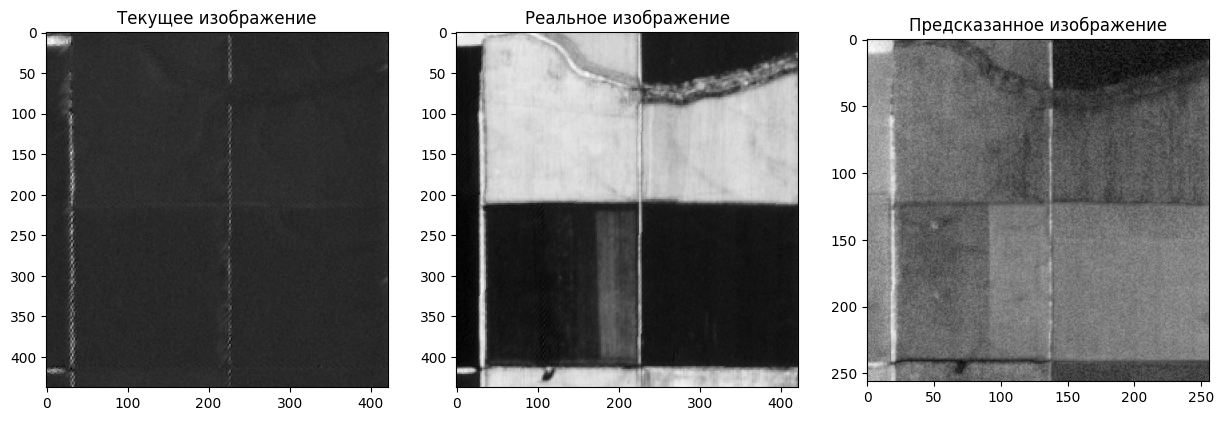

Предсказанная урожайность: [[65.906006 61.29235 ]]


In [ ]:
# 75 Эпоха
import matplotlib.pyplot as plt
model.eval()

# Преобразование для входных изображений
transform = transforms.Compose([transforms.ToTensor()])

# Функция для предсказания следующего изображения и урожайности
def predict_next_image(model, current_image_path, feature_data, transform):
    model.eval()

    # Подготовка текущего изображения
    current_img = tifffile.imread(current_image_path)
    current_img = cv2.resize(current_img / 10000, (256, 256))
    current_img = transform(current_img).view(1, 1, 256 * 256).float()

    # Подготовка признаков (нужно обеспечить правильный размер)
    feature_inputs = torch.tensor(feature_data).view(1, -1, 25).float()  

    with torch.no_grad():
        predicted_image, predicted_features = model(current_img, feature_inputs)

    return predicted_image.view(256, 256).numpy(), predicted_features.numpy()

# Путь к текущему изображению и реальному следующему изображению
current_image_path = 'fields_int16\\40_2023-02-09.tiff'
real_image_path = 'fields_int16\\41_2023-07-04.tiff'

# Пример данных для features
# features должны соответствовать данным, используемым при обучении модели
feature_data = np.concatenate((features[:6], features[7:7+6]), axis=0) 

# Предсказание следующего изображения и урожайности
predicted_image, predicted_features = predict_next_image(model, current_image_path, feature_data, transform)

# Отображение текущего, реального и предсказанного изображения
current_img = tifffile.imread(current_image_path)
real_img = tifffile.imread(real_image_path)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(current_img, cmap='gray')
plt.title('Текущее изображение')

plt.subplot(1, 3, 2)
plt.imshow(real_img, cmap='gray')
plt.title('Реальное изображение')

plt.subplot(1, 3, 3)
plt.imshow(predicted_image, cmap='gray')
plt.title('Предсказанное изображение')

plt.show()

print("Предсказанная урожайность:", predicted_features)

In [175]:
# Альтернативная модель без использования targets
import tifffile
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
from sklearn.metrics import mean_squared_error
torch.manual_seed(0)

def extract_image_number(file_name):
    return int(file_name.split('_')[0])  # Предполагаем, что порядковый номер разделен символом '_'

class ImagePredictionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ImagePredictionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1])  # Используем только последний выход LSTM
        return output

# Определение класса датасета
class ImageSequenceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(root_dir), key=extract_image_number)

    def __len__(self):
        return len(self.image_files) - 1  # Мы предсказываем следующее изображение, поэтому на 1 меньше

    def __getitem__(self, idx):
        current_img_path = os.path.join(self.root_dir, self.image_files[idx])
        next_img_path = os.path.join(self.root_dir, self.image_files[idx + 1])

        current_img = tifffile.imread(current_img_path)
        next_img = tifffile.imread(next_img_path)
        current_img = cv2.resize(current_img / 10000, (256, 256))
        next_img = cv2.resize(next_img / 10000, (256, 256))


        if self.transform:
            current_img = self.transform(current_img)
            next_img = self.transform(next_img)

        return {'input': current_img, 'target': next_img}

# Пример использования
root_directory = 'fields_int16'
transform = transforms.Compose([transforms.ToTensor()])  # Преобразование изображения в тензор

dataset = ImageSequenceDataset(root_directory, transform=transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Параметры модели
input_size = 256 * 256  # Размер входного вектора (RGB изображение 256x256)
hidden_size = 64
output_size = input_size

# Инициализация модели, функции потерь и оптимизатора
model = ImagePredictionModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# бучение модели
num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch['input'].view(-1, 1, 256*256).float()  # Используем один канал, добавляем размерность батча
        targets = batch['target'].view(-1, input_size).float()
        optimizer.zero_grad()
        outputs = model(inputs)

        predicted_images = outputs.view(-1, 256, 256)
        target_images = targets.view(-1, 256, 256)

        loss = criterion(predicted_images, target_images)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 0.0998
Epoch [2/50], Loss: 0.1376
Epoch [3/50], Loss: 0.0647
Epoch [4/50], Loss: 0.0714
Epoch [5/50], Loss: 0.0223
Epoch [6/50], Loss: 0.0935
Epoch [7/50], Loss: 0.0122
Epoch [8/50], Loss: 0.1427
Epoch [9/50], Loss: 0.0712
Epoch [10/50], Loss: 0.1437
Epoch [11/50], Loss: 0.0218
Epoch [12/50], Loss: 0.0177
Epoch [13/50], Loss: 0.0698
Epoch [14/50], Loss: 0.0260
Epoch [15/50], Loss: 0.0298
Epoch [16/50], Loss: 0.1649
Epoch [17/50], Loss: 0.0212
Epoch [18/50], Loss: 0.0945
Epoch [19/50], Loss: 0.0815
Epoch [20/50], Loss: 0.0848
Epoch [21/50], Loss: 0.0125
Epoch [22/50], Loss: 0.0816
Epoch [23/50], Loss: 0.0122
Epoch [24/50], Loss: 0.0688
Epoch [25/50], Loss: 0.0306
Epoch [26/50], Loss: 0.0866
Epoch [27/50], Loss: 0.1089
Epoch [28/50], Loss: 0.0498
Epoch [29/50], Loss: 0.0457
Epoch [30/50], Loss: 0.0248
Epoch [31/50], Loss: 0.0787
Epoch [32/50], Loss: 0.0129
Epoch [33/50], Loss: 0.0360
Epoch [34/50], Loss: 0.1376
Epoch [35/50], Loss: 0.0138
Epoch [36/50], Loss: 0.1036
E